In [1]:
import os

import argparse
import time
import torch
from datasets import load_dataset
import torch.nn as nn
import numpy as np
from utils_oke import SNR_to_noise, val_step_with_smart_simple_JSCC,  train_step_hyperprior, train_step_modulated_adv
from models_2.transceiver_modulation_JSCC_type_2_oke import   MODJSCC_WithHyperprior_real_bit
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
from utils_oke import PowerNormalize, Channels
from matplotlib import pyplot as plt
import torch
torch.autograd.set_detect_anomaly(True)

In [2]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
parser = argparse.ArgumentParser()

In [3]:
from collections import Counter
import heapq

In [4]:
def preprocess_sst2(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=64)

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
plt.rcParams['ps.fonttype'] = 42

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
AWGN @-20.0dB:   0%|          | 0/14 [00:00<?, ?it/s]/home/necphy/ducjunior/openbackdoor/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Rician @20.0dB: 100%|██████████| 14/14 [00:00<00:00, 49.47it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


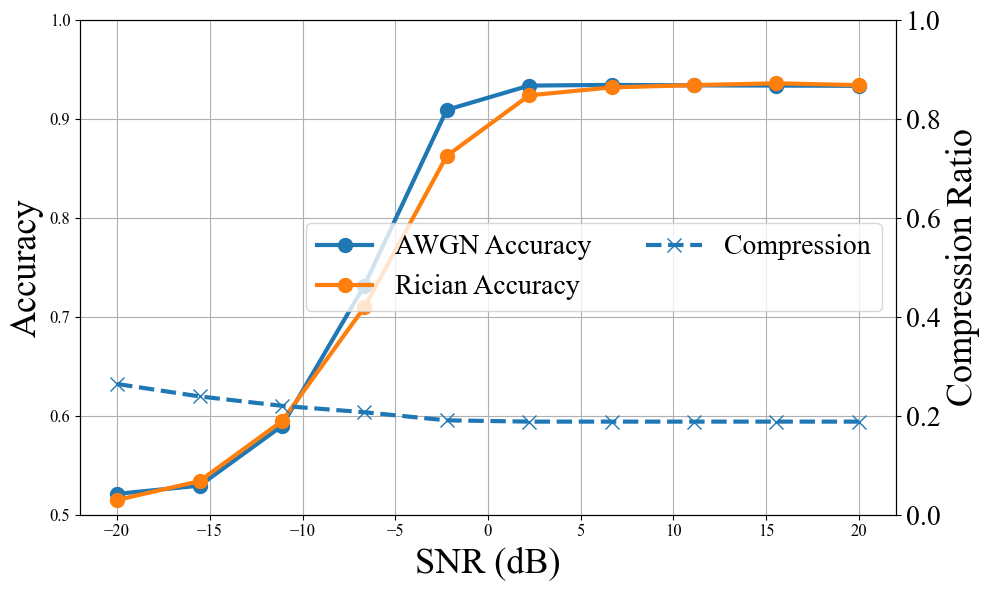

In [6]:
def evaluate(model, dataloader, channel, snr_db, device):
    """
    Runs inference on `dataloader` through `channel_fn` at SNR=snr_db (dB).
    Returns: (accuracy, avg_bits_per_sample).
    """
    model.eval()
    correct = 0
    total = 0
    total_bits = 0.0

    # convert dB → noise variance
    n_var = 10 ** (-snr_db / 10)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"{channel} @{snr_db}dB"):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['label'].to(device)

            logits, rate_loss, _ = model(input_ids, attention_mask, n_var, channel=channel)

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

            total_bits += rate_loss.item() * labels.size(0)

    acc = correct / total
    avg_bits_per_sample = total_bits / total
    return acc, avg_bits_per_sample

# ── 2) Prepare your test loader ────────────────────────────────────────────────
# Replace `preprocess_sst2` with your actual preprocessing function
ds = load_dataset("glue", "sst2")
test_ds = ds["validation"].map(preprocess_sst2, batched=True)
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# ── 3) Load your model ─────────────────────────────────────────────────────────
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MODJSCC_WithHyperprior_real_bit(d_model=256, freeze_bert=False).to(device)
checkpoint = torch.load("/home/necphy/ducjunior/BERT_Backdoor/checkpoints/JSSC_new_model_MoE/checkpoint_full08.pth", map_location=device)
model.load_state_dict(checkpoint, strict=True)
channels = Channels()  # Ensure Channels().AWGN and Channels().Rayleigh are defined

# ── 4) SNR sweep and results collection ────────────────────────────────────────
snr_dbs = np.linspace(-20, 20, num=10)  # adjust as needed
raw_bits_per_sample = 128 * 16  # e.g. sequence_length * bits_per_token

n_runs = 5  # number of independent runs to average over
N_s = model.N_s
capacity_bits = N_s * np.log2(1 + 10**(snr_dbs / 10))
capacity_ratio = capacity_bits / raw_bits_per_sample
# ── 2) Allocate storage ───────────────────────────────────────────────────────
acc = {
    'AWGN':    np.zeros((n_runs, len(snr_dbs))),
    # 'Rayleigh':np.zeros((n_runs, len(snr_dbs))),
    'Rician':np.zeros((n_runs, len(snr_dbs)))
}
comp = {
    'AWGN':    np.zeros((n_runs, len(snr_dbs)))
    # 'Rayleigh':np.zeros((n_runs, len(snr_dbs)))
}

# ── 3) Run multiple times ─────────────────────────────────────────────────────
for run in range(n_runs):
    for idx, snr in enumerate(snr_dbs):
        # evaluate on AWGN
        a_awgn, b_awgn = evaluate(model, test_loader, "AWGN", snr, device)
        acc['AWGN'][run, idx] = a_awgn
        comp['AWGN'][run, idx] = b_awgn / raw_bits_per_sample

        # evaluate on Rayleigh
        # a_ray, b_ray = evaluate(model, test_loader, "Rayleigh", snr, device)
        # acc['Rayleigh'][run, idx] = a_ray
        a_ray, b_ray = evaluate(model, test_loader, "Rician", snr, device)
        acc['Rician'][run, idx] = a_ray
        # comp['Rayleigh'][run, idx] = b_ray / raw_bits_per_sample

# ── 4) Compute mean curves ────────────────────────────────────────────────────
mean_acc  = {ch: acc[ch].mean(axis=0)  for ch in acc}
mean_comp = {ch: comp[ch].mean(axis=0) for ch in comp}

# ── 5) Plot on twin axes ──────────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(10,6))
import matplotlib.font_manager as fm
paths = [
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
    ]
for p in paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
plt.rcParams['ps.fonttype'] = 42
ax2 = ax1.twinx()

# Accuracy curves (left axis)
for ch, vals in mean_acc.items():
    ax1.plot(snr_dbs, vals, marker='o', linestyle='-', label=f"{ch} Accuracy",linewidth=3,markersize=10)

# Compression curves (right axis)
for ch, vals in mean_comp.items():
    ax2.plot(snr_dbs, vals, marker='x', linestyle='--', label=f"Compression",linewidth=3,markersize=10)
    
# ax2.plot(snr_dbs, capacity_ratio, marker='s', linestyle='-.', label="Shannon Bound")
# Labels & legend
ax1.set_xlabel("SNR (dB)", fontsize=26)
ax1.set_ylim(0.5,1)
ax1.set_ylabel("Accuracy", fontsize=26)
ax2.set_ylabel("Compression Ratio", fontsize=26)
ax2.set_ylim(0,1)
ax1.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right", ncol=2)

# plt.title(f"Mean Accuracy & Compression vs. SNR over {n_runs} runs", fontsize=16)
plt.tight_layout()
plt.savefig("cleanperform.eps", format='eps', bbox_inches='tight')
plt.show()

In [7]:
# from collections import Counter
# import heapq
# import math
# import numpy as np
# import matplotlib.pyplot as plt
# import itertools

# # --- (A) Compute Huffman baseline bits/token ---
# # 1) Gather byte‐freqs on your train split
# byte_counts = Counter()

# ds =   load_dataset("glue", "sst2")
# # ds_encoded = ds.map(preprocess_sst2, batched=True)
# # ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
# train_dataset = ds["train"]
# for ex in train_dataset:               # e.g. ds["train"]
#     data = ex["sentence"].encode("utf-8")
#     byte_counts.update(data)

 
# from collections import Counter
# import heapq
# import itertools

# # 1) Build a pure-bytes frequency map
# byte_counts = {bytes([b]): 0 for b in range(256)}
# for ex in train_dataset:            # your SST-2 train split
#     data = ex["sentence"].encode("utf-8")
#     for b in data:
#         byte_counts[bytes([b])] += 1

# # 2) Build heap with tie-breaker
# counter = itertools.count()
# heap = [(freq, next(counter), sym) for sym, freq in byte_counts.items()]
# heapq.heapify(heap)

# # 3) Merge to single-node tree
# while len(heap) > 1:
#     f1, _, n1 = heapq.heappop(heap)
#     f2, _, n2 = heapq.heappop(heap)
#     heapq.heappush(heap, (f1+f2, next(counter), (n1, n2)))

# # 4) Extract root and assign codes
# _, _, root = heap[0]
# def assign_codes(node, prefix="", cmap=None):
#     if cmap is None:
#         cmap = {}
#     if isinstance(node, bytes):
#         cmap[node] = prefix or "0"
#     else:
#         left, right = node
#         assign_codes(left,  prefix + "0", cmap)
#         assign_codes(right, prefix + "1", cmap)
#     return cmap

# huff_codes = assign_codes(root)

# # 5) Now compute avg bits/token safely
# total_bits, total_tokens = 0, 0
# for ex in ds["validation"]:
#     data = ex["sentence"].encode("utf-8")
#     bits = sum(len(huff_codes[bytes([b])]) for b in data)
#     total_bits += bits
#     total_tokens += len(ex["sentence"].split())
# avg_bits_huff = total_bits / total_tokens
# baseline_ratio = avg_bits_huff / math.log2(30000)

# print(f"Huffman bits/token: {avg_bits_huff:.3f}, ratio={baseline_ratio:.3f}")

# cap_bits = N_s * np.log2(1 + 10**(snr_dbs/10))
# B_huff = avg_bits_huff * L         # Huffman bits per sample
# tx_sep  = np.maximum(B_huff, cap_bits)

# # --- (C) Plot everything ---
# fig, ax1 = plt.subplots(figsize=(8,5))
# ax2 = ax1.twinx()

# # 1) JSCC accuracy (left axis)
# for ch, vals in mean_acc.items():
#     ax1.plot(snr_dbs, vals, marker='o', label=f"{ch} Accuracy")

# # 2) JSCC compression (right axis)
# for ch, vals in mean_comp.items():
#     ax2.plot(snr_dbs, vals, marker='x', linestyle='--', label=f"{ch} Compression")

# # # 3) Huffman baseline (right axis)
# capacity_bits        = N_s * np.log2(1 + 10**(snr_dbs/10))       # bits/sample
# capacity_per_token   = capacity_bits / 64                # bits/token
# sep_ratio            = capacity_per_token / math.log2(30000)        # normalized
# # 4) Ideal separation (right axis)
# ax2.plot(snr_dbs, sep_ratio,
#          marker='s', linestyle='-.',
#          label="Huffman + ideal LDPC")

# # Labels & legend
# ax1.set_xlabel("SNR (dB)", fontsize=14)
# ax1.set_ylabel("Accuracy",    fontsize=14)
# ax2.set_ylabel("Compression Ratio", fontsize=14)
# ax1.grid(True)

# # Combine legends
# l1, lab1 = ax1.get_legend_handles_labels()
# l2, lab2 = ax2.get_legend_handles_labels()
# ax1.legend(l1 + l2, lab1 + lab2, loc='best', ncol=2)

# plt.title("JSCC vs. Huffman & Separation Bounds", fontsize=16)
# plt.tight_layout()
# plt.show()


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ── Assumed precomputed from your evaluation loop ────────────────────────────
# # snr_dbs       : np.ndarray of your SNR points (in dB)
# # mean_acc      : dict of JSCC accuracy curves, e.g. {'AWGN': [...], 'Rician': [...]}
# # bits_store    : dict storing raw bits_per_sample arrays shape (n_runs, len(snr_dbs))
# #                 e.g. bits_store = {'AWGN': awgn_bits_array, 'Rician': rician_bits_array}
# # avg_bits_huff : float, bits/token from your UTF-8+Huffman baseline on val set
# # seq_len       : int, tokens per sample (e.g. 64)

# # 1) Compute mean bits/sample for JSCC
# mean_bits = {ch: bits_store[ch].mean(axis=0) for ch in bits_store}

# # 2) Baseline bits/sample (Huffman only, tokens→bits/sample)
# baseline_bits_per_sample = avg_bits_huff * seq_len

# # ── Plot ────────────────────────────────────────────────────────────────────
# fig, ax1 = plt.subplots(figsize=(8,5))
# ax2 = ax1.twinx()

# # Accuracy (left axis)
# for ch, acc_vals in mean_acc.items():
#     ax1.plot(snr_dbs, acc_vals,
#              marker='o', linestyle='-',
#              label=f"{ch} Accuracy")

# # JSCC bits/sample (right axis)
# for ch, bit_vals in mean_bits.items():
#     ax2.plot(snr_dbs, bit_vals,
#              marker='x', linestyle='--',
#              label=f"{ch} Bits/Sample")

# # Huffman baseline bits/sample (horizontal)
# ax2.hlines(baseline_bits_per_sample,
#            snr_dbs.min(), snr_dbs.max(),
#            colors='red', linestyles=':',
#            linewidth=2,
#            label="UTF-8+Huffman Bits/Sample")

# # Labels & legend
# ax1.set_xlabel("SNR (dB)", fontsize=14)
# ax1.set_ylabel("Accuracy", fontsize=14)
# ax2.set_ylabel("Bits per Sample", fontsize=14)
# ax1.grid(True)

# # Combine legends
# h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1+h2, l1+l2, loc='best', ncol=2)

# plt.title("JSCC Accuracy & Bits/Sample vs. SNR\nwith UTF-8+Huffman Baseline", fontsize=16)
# plt.tight_layout()
# plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


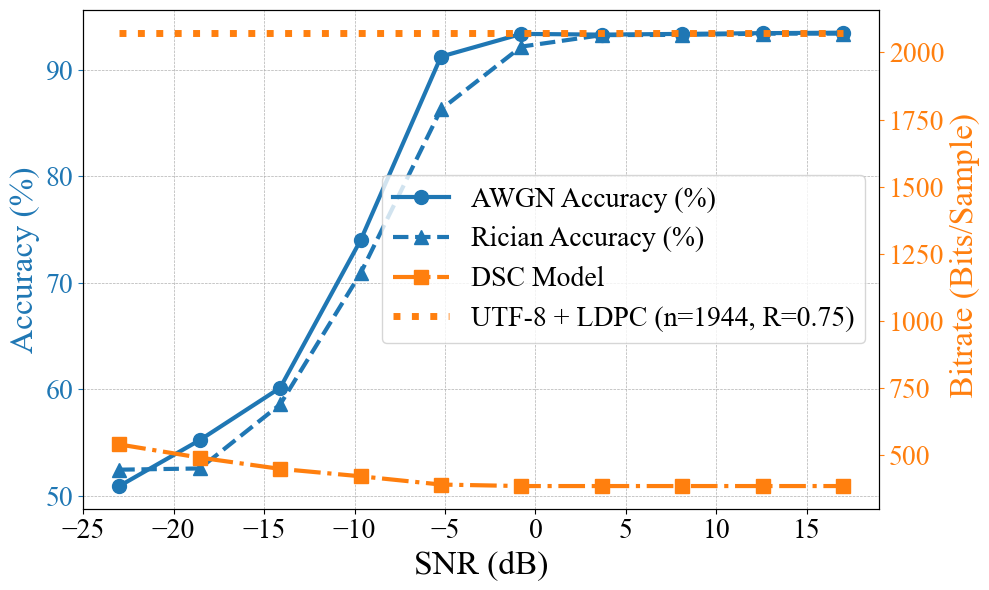

In [ ]:
import torch
import matplotlib.font_manager as fm
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
import heapq, itertools

# Replace these imports with your actual module paths
LDPC_N = 1944     # or 64800 for DVB-S2
LDPC_R = 0.75     # pick 0.5, 2/3, 3/4, 5/6, etc.

def ldpc_encoded_bits(L_bits, n=LDPC_N, R=LDPC_R):
    """
    L_bits : number of uncoded bits in the message
    n      : LDPC codeword length (blocklength)
    R      : LDPC code rate (k/n)
    Returns total coded bits with block segmentation & padding.
    """
    k = int(math.floor(n * R))           # info bits per block
    if k <= 0:
        return 0
    nblocks = math.ceil(L_bits / k)      # how many LDPC blocks we need
    return nblocks * n                   # each block emits n coded bits

# Average coded bits per *model input sample* (match your validation set)
total_coded_bits = 0
num_samples = 0
for ex in ds["validation"]:
    # Raw UTF-8 bits for the *original sentence*
    L_bits = 8 * len(ex["sentence"].encode("utf-8"))
    total_coded_bits += ldpc_encoded_bits(L_bits, LDPC_N, LDPC_R)
    num_samples += 1

baseline_bits_per_sample = total_coded_bits / num_samples


def evaluate(model, dataloader, channel_fn, snr_db, device):
    model.eval()
    correct = total = 0
    total_bits = 0.0
    n_var = 10 ** (-snr_db / 10)

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits, rate_loss, _ = model(input_ids, attention_mask, n_var, channel_fn)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_bits += rate_loss.item() * labels.size(0)

    acc = correct / total
    bits_per_sample = total_bits / total
    return acc, bits_per_sample

# Prepare dataset
ds = load_dataset("glue", "sst2")
val_ds = ds["validation"].map(preprocess_sst2, batched=True)
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# Load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MODJSCC_WithHyperprior_real_bit(d_model=256, freeze_bert=False).to(device)
checkpoint = torch.load('/home/necphy/ducjunior/BERT_Backdoor/checkpoints/JSSC_new_model_MoE/checkpoint_full08.pth', map_location=device)
model.load_state_dict(checkpoint, strict=True)
channels = Channels()

# Define SNR sweep
snr_dbs = np.linspace(-20, 20, num=10)
n_runs = 5
seq_len = 64

# Storage
acc_store = {'AWGN': np.zeros((n_runs, len(snr_dbs))),
            #  'Rayleigh': np.zeros((n_runs, len(snr_dbs))),
             'Rician': np.zeros((n_runs, len(snr_dbs)))}
bits_store = {'AWGN': np.zeros((n_runs, len(snr_dbs)))
              }

# Run evaluation
for run in range(n_runs):
    for idx, snr in enumerate(snr_dbs):
        a_awgn, b_awgn = evaluate(model, val_loader,  "AWGN", snr, device)
        acc_store['AWGN'][run, idx] = a_awgn
        bits_store['AWGN'][run, idx] = b_awgn

        a_ric, b_ric = evaluate(model, val_loader, 'Rician', snr, device)
        acc_store['Rician'][run, idx] = a_ric
        # a_ray, b_ray = evaluate(model, val_loader, 'Rayleigh', snr, device)
        # acc_store['Rayleigh'][run, idx] = a_ray
        # bits_store['Rician'][run, idx] = b_ric

# Compute means
mean_acc = {ch: acc_store[ch].mean(axis=0) for ch in acc_store}
mean_bits = {ch: bits_store[ch].mean(axis=0) for ch in bits_store}

# Huffman baseline bits/sample
train_ds = ds["train"]
byte_counts = {bytes([b]): 0 for b in range(256)}
for ex in train_ds:
    data = ex["sentence"].encode("utf-8")
    for b in data:
        byte_counts[bytes([b])] += 1

counter = itertools.count()
heap = [(freq, next(counter), sym) for sym, freq in byte_counts.items()]
heapq.heapify(heap)
while len(heap) > 1:
    f1, _, n1 = heapq.heappop(heap)
    f2, _, n2 = heapq.heappop(heap)
    heapq.heappush(heap, (f1+f2, next(counter), (n1, n2)))
_, _, root = heap[0]

def assign_codes(node, prefix="", cmap=None):
    if cmap is None:
        cmap = {}
    if isinstance(node, bytes):
        cmap[node] = prefix or "0"
    else:
        left, right = node
        assign_codes(left,  prefix + "0", cmap)
        assign_codes(right, prefix + "1", cmap)
    return cmap

huff_codes = assign_codes(root)

total_bits = total_tokens = 0
for ex in ds["validation"]:
    data = ex["sentence"].encode("utf-8")
    bits = sum(len(huff_codes[bytes([b])]) for b in data)
    total_bits += bits
    total_tokens += len(ex["sentence"].split())
avg_bits_huff = total_bits / total_tokens
baseline_bits_per_sample = avg_bits_huff * seq_len

import matplotlib.pyplot as plt

LDPC_N = 1944     # or 64800 for DVB-S2
LDPC_R = 0.75     # pick 0.5, 2/3, 3/4, 5/6, etc.

def ldpc_encoded_bits(L_bits, n=LDPC_N, R=LDPC_R):
    """
    L_bits : number of uncoded bits in the message
    n      : LDPC codeword length (blocklength)
    R      : LDPC code rate (k/n)
    Returns total coded bits with block segmentation & padding.
    """
    k = int(math.floor(n * R))           # info bits per block
    if k <= 0:
        return 0
    nblocks = math.ceil(L_bits / k)      # how many LDPC blocks we need
    return nblocks * n                   # each block emits n coded bits

# Average coded bits per *model input sample* (match your validation set)
total_coded_bits = 0
num_samples = 0
for ex in ds["validation"]:
    # Raw UTF-8 bits for the *original sentence*
    L_bits = 8 * len(ex["sentence"].encode("utf-8"))
    total_coded_bits += ldpc_encoded_bits(L_bits, LDPC_N, LDPC_R)
    num_samples += 1

baseline_bits_per_sample = total_coded_bits / num_samples


# — get default color cycle (blue, orange, green, …) —
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_acc, color_bits = colors[0], colors[1]

# — define per-curve markers & linestyles —
acc_markers     = {'AWGN': 'o',    'Rician': '^'}
acc_linestyles  = {'AWGN': '-',    'Rician': '--'}
bits_markers    = {'AWGN': 's'}        # add more if you plot multiple
bits_linestyles = {'AWGN': '-.'}       # choose a different style
baseline_ls     = ':'                  # baseline linestyle

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# — plot accuracy (all default-blue) —
for ch, acc_vals in mean_acc.items():
    ax1.plot(
        snr_dbs-3, acc_vals*100,  # convert to percentage
        color=color_acc,
        marker=acc_markers[ch],
        linestyle=acc_linestyles[ch],
        linewidth=3,
        markersize=10,
        label=f"{ch} Accuracy (%)"
    )

# — plot bits/sample (all default-orange) —
for ch, bits_vals in mean_bits.items():
    ax2.plot(
        snr_dbs-3, bits_vals,
        color=color_bits,
        marker=bits_markers[ch],
        linestyle=bits_linestyles[ch],
        linewidth=3,
        markersize=10,
        label=f"DSC Model"
    )

# — plot baseline in same orange —
# ax2.hlines(
#     baseline_bits_per_sample,
#     xmin=snr_dbs.min(),
#     xmax=snr_dbs.max(),
#     color=color_bits,
#     linestyle=baseline_ls,
#     linewidth=5,
#     label="UTF-8 + LDPC "
# )
ax2.hlines(
    baseline_bits_per_sample,
    xmin=snr_dbs.min()-3, xmax=snr_dbs.max()-3,
    linestyle=':', linewidth=5,color=color_bits,
    label=f"UTF-8 + LDPC (n={LDPC_N}, R={LDPC_R:g})"
)

# — axis labels (matching colors) —
ax1.set_xlabel("SNR (dB)")
ax1.set_ylabel("Accuracy (%)",        color=color_acc)
ax2.set_ylabel(" Bitrate (Bits/Sample)",  color=color_bits)3

ax1.tick_params(axis='y', colors=color_acc)
ax2.tick_params(axis='y', colors=color_bits)

ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# — combined legend —
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='center right')

plt.tight_layout()
fig.savefig("jscc_performance_clean_3.eps",
                format='eps', bbox_inches='tight')
plt.show()
